In [1]:
import os 

import numpy as np
import scipy.stats as sps
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

import sys, os
sys.path += [os.path.abspath(os.pardir + '/code')]
print(sys.path)

from experiment import init_random_state, BanditLoopExperiment, get_ts_model

sns.set(font_scale=1.2, palette='tab20') 

['/home/anton/Desktop/m1p/2021-Project-74/notebooks', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/anton/.local/lib/python3.8/site-packages', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages', '/home/anton/.local/lib/python3.8/site-packages/IPython/extensions', '/home/anton/.ipython', '/home/anton/Desktop/m1p/2021-Project-74/code']


In [2]:
seed = 42

p = 0.9
Q = 1
w = 4
b = 0.0

T = 2000

Ml = []
for i in range(2, 11):
    for j in range(1, i):
        Ml.append((i, j))
print(Ml)

[(2, 1), (3, 1), (3, 2), (4, 1), (4, 2), (4, 3), (5, 1), (5, 2), (5, 3), (5, 4), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (10, 7), (10, 8), (10, 9)]


In [3]:
interests, responses = [], []

In [4]:
for i, (M, l) in enumerate(Ml):
    init_random_state(seed)
    
    bandit = lambda: get_ts_model(M=M, l=l)
    exp = BanditLoopExperiment(bandit, "TS bandit")
    exp.prepare(w=w, Q=Q, p=p, b=b)
    exp.run_experiment(T=T)
    
    results = exp.get_as_np()
    interests.append(results.interest)
    responses.append(results.response)

In [5]:
responses[4].shape

(2000, 2)

In [6]:
sum_responces = []
for i in range(len(Ml)):  
    sum_responces.append(np.cumsum(responses[i].reshape(2000, -1).sum(axis=1)))

sum_responces = np.array(sum_responces)
sum_responces.shape

(45, 2000)

In [7]:
sum_interests = []
for i in range(len(Ml)):  
    sum_interests.append(np.linalg.norm(interests[i] - interests[i][0], axis=1)**2)
    
sum_interests = np.array(sum_interests)
sum_interests.shape

(45, 2000)

In [8]:
np.vstack([np.concatenate(sum_interests).reshape(1, -1), np.concatenate(sum_interests).reshape(1, -1)]).shape

(2, 90000)

In [9]:
data = pd.DataFrame(np.vstack([np.concatenate(sum_interests).reshape(1, -1), np.concatenate(sum_interests).reshape(1, -1)]).T, columns=['Norm interests', 'Sum response']) 
data['M'] = 0
data['l'] = 0
data['t'] = 0
for i, (M, l) in enumerate(Ml):
    data['M'][i*T:(i+1)*T] = M
    data['l'][i*T:(i+1)*T] = l
    data['t'][i*T:(i+1)*T] = np.arange(T)+1

<ipython-input-9-4cc1a203b12b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['M'][i*T:(i+1)*T] = M
/home/anton/.local/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-9-4cc1a203b12b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['l'][i*T:(i+1)*T] = l
<ipython-input-9-4cc1a203b12b>:8: SettingWithCopyWarning: 
A

In [10]:
data.head()

,Norm interests,Sum response,M,l,t
0,0.000000,0.000000,2,1,1
1,0.000002,0.000002,2,1,2
2,0.000010,0.000010,2,1,3
3,0.000054,0.000054,2,1,4
4,0.000261,0.000261,2,1,5


In [11]:
last_val = data[data['t']==2000]

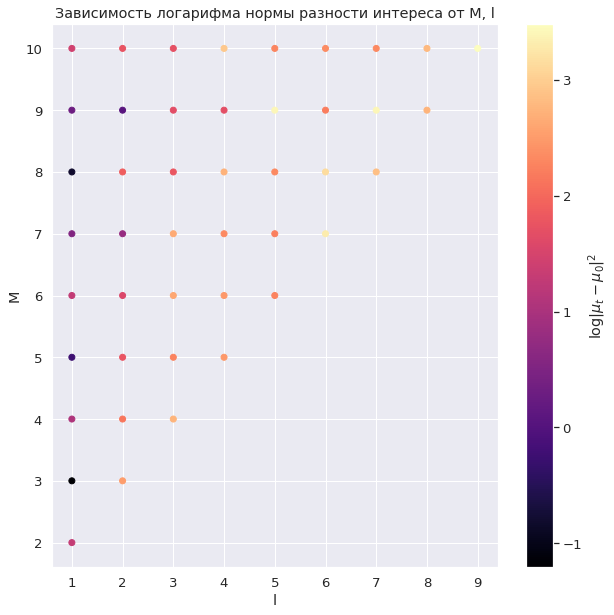

In [13]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

y = last_val['M']
x = last_val['l']
c = last_val['Sum response']

ax.set_xlabel("l")
ax.set_ylabel("M")

p = ax.scatter(x, y, c=np.log(c), cmap='magma')
plt.title('Зависимость логарифма нормы разности интереса от M, l')
cbar = fig.colorbar(p, ax=ax)
cbar.set_label(r'$\log \|\mu_t - \mu_0 \|^2$')

plt.savefig('plot_Ml.pdf')

plt.show()

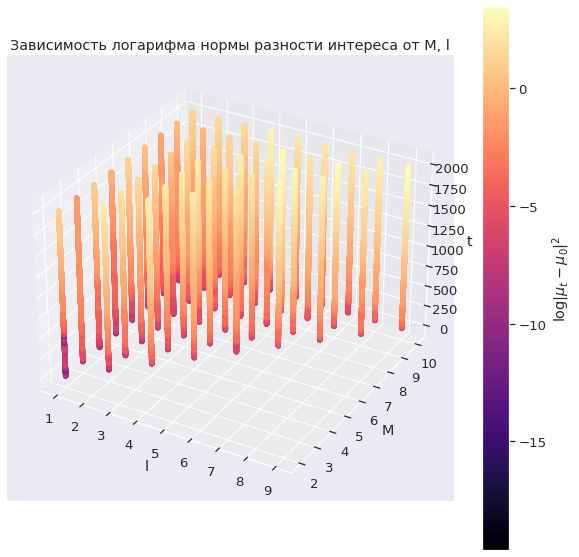

In [15]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection = '3d')

z = data['t']
y = data['M']
x = data['l']
c = data['Sum response']

ax.set_xlabel("l")
ax.set_ylabel("M")
ax.set_zlabel("t")

p = ax.scatter(x, y, z, c=np.log(c), cmap='magma')
plt.title('Зависимость логарифма нормы разности интереса от M, l')
cbar = fig.colorbar(p, ax=ax)
cbar.set_label(r'$\log \|\mu_t - \mu_0 \|^2$')

plt.savefig('3d_plot_Ml.pdf')

plt.show()